In [26]:
#Joshua Pan AI2ES June 2021
#Create a time series of average Canny edged values to find foggy images. Separate images into day (color) and night (grayscale) mode.
import os
import time
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import datetime as dt
from eofs.xarray import Eof
import cv2
import urllib

In [2]:
#read most recent camera direction for each station into a dict
CAMDIRFILE = '/tf/camdir.txt'
f = open(CAMDIRFILE, 'r')
[f.readline() for i in range(3)]

currentdirs = dict()
for line in f:
    line = line.split('|')
    stn = line[1][1:-1]
    date = line[2][1:-1]
    hdg = int(line[3][1:-3])
    currentdirs[stn] = (hdg, date)
#print(currentdirs)

2016-06-23 15:00:00 ['20160623T150004_PENN.jpg']


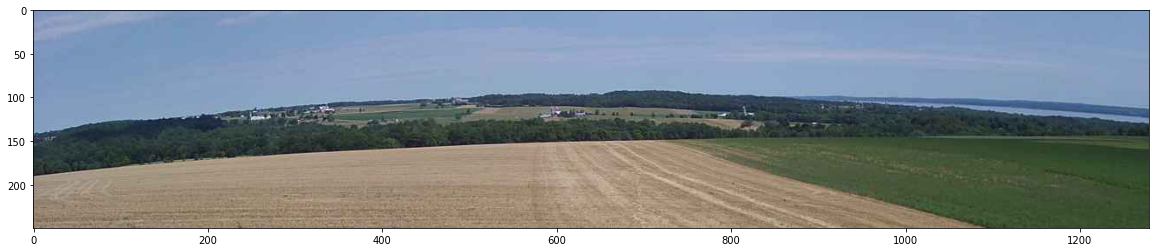

In [24]:
#open an image from a station, where the cam is facing its current direction
import glob
import matplotlib.image as mpimg

STN = 'PENN'
ASOS = 'PEO'
startdate = dt.datetime.strptime(currentdirs[STN][1], '%Y-%m-%d %H:%M:%S') + dt.timedelta(days=30) #skip some time to ensure cam is running
startdate -= dt.timedelta(minutes=startdate.minute)
IMGDIR = '/tf/NYSM/archive/nysm/cam_photos'
imgsubdir = '{:04d}/{:02d}/{:02d}/{}'.format(startdate.year, startdate.month, startdate.day, STN)
os.chdir(os.path.join(IMGDIR, imgsubdir))
imgfile = glob.glob('{:04d}{:02d}{:02d}T{:02d}{:02d}*'.format(startdate.year, startdate.month, startdate.day, startdate.hour, startdate.minute // 60 * 60))
print(startdate, imgfile)
image = mpimg.imread(imgfile[0])
plt.rcParams['figure.figsize'] = [20, 8]
y0 = 100
y1 = 350
x0 = 0
x1 = 1280
plt.imshow(image[y0:y1, x0:x1, :])

In [4]:
def isdaytime(image):
    """
    Returns whether NYSM image was taken in day (color) or night (grayscale) mode.
    :rtype: boolean
    """
    return not (image == cv2.cvtColor(image, cv2.COLOR_RGB2BGR)).all()

In [5]:
#set up for loop through files
hours = (0, int(2 * 365 * 24))
timestamps, grayimgs = [], [] #timestamps will be the time coords of the DataArray. DataArray will also have x and y coords.

In [6]:
%%time
#compute a Canny edge score time series (score is proportion of edge pixels * 255)
for hour in range (*hours): #hours since startdate
    date = cftime.num2date(hour, 'hours since %s' % startdate)
    if date.day == 1 and date.hour == 0:
        print('Working on date %s' % str(date))
    
    imgsubdir = '{:04d}/{:02d}/{:02d}/{}'.format(date.year, date.month, date.day, STN)
    try:
        os.chdir(os.path.join(IMGDIR, imgsubdir))
        imgfile = glob.glob('{:04d}{:02d}{:02d}T{:02d}{:02d}*'.format(date.year, date.month, date.day, date.hour, date.minute // 60 * 60))
        image = mpimg.imread(imgfile[0])
        timestamps.append(date)
        grayimgs.append(cv2.cvtColor(image[y0:y1, x0:x1, :], cv2.COLOR_RGB2GRAY))
    except:
        None

Working on date 2016-07-01 00:00:00
Working on date 2016-08-01 00:00:00
Working on date 2016-09-01 00:00:00
Working on date 2016-10-01 00:00:00
Working on date 2016-11-01 00:00:00
Working on date 2016-12-01 00:00:00
Working on date 2017-01-01 00:00:00
Working on date 2017-02-01 00:00:00
Working on date 2017-03-01 00:00:00
Working on date 2017-04-01 00:00:00
Working on date 2017-05-01 00:00:00
Working on date 2017-06-01 00:00:00
Working on date 2017-07-01 00:00:00
Working on date 2017-08-01 00:00:00
Working on date 2017-09-01 00:00:00
Working on date 2017-10-01 00:00:00
Working on date 2017-11-01 00:00:00
Working on date 2017-12-01 00:00:00
Working on date 2018-01-01 00:00:00
Working on date 2018-02-01 00:00:00
Working on date 2018-03-01 00:00:00
Working on date 2018-04-01 00:00:00
Working on date 2018-05-01 00:00:00
Working on date 2018-06-01 00:00:00
CPU times: user 18min 12s, sys: 17min 26s, total: 35min 38s
Wall time: 5min 58s


(17271, 250, 1280)


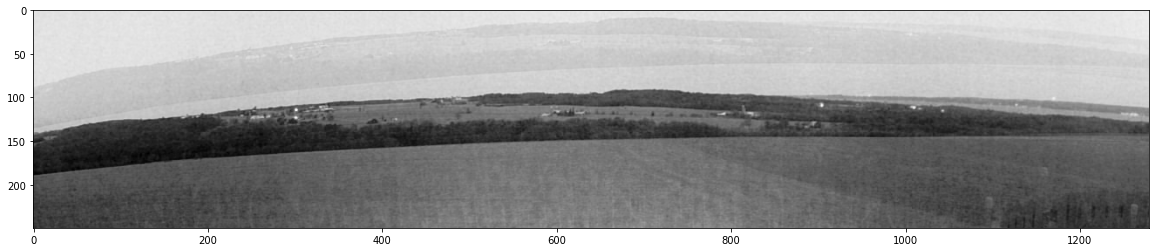

In [7]:
#create a 3D DataArray (time, x, y) whose values are the brightness of the grayscale images
xs = np.arange(0, grayimgs[0].shape[1], 1)
ys = np.arange(0, grayimgs[0].shape[0], 1)
grayimgs = np.array(grayimgs) #turn list of imgs into 3D numpy array.
print(grayimgs.shape)
imgda = xr.DataArray(grayimgs, dims = ['time', 'y', 'x'], coords = [timestamps, ys, xs])
imgdamean = imgda.mean(dim = 'time')
imgdaanom = imgda - imgdamean
#plt.imshow(imgdaanom.sel(time = imgdaanom.coords['time'].values[100]), cmap = 'Greys_r')
plt.imshow(imgdamean, cmap = 'Greys_r')

In [8]:
%%time
#compute EOFs
solver = Eof(imgdaanom)

CPU times: user 3d 7h 44min 36s, sys: 1d 12h 29min 39s, total: 4d 20h 14min 15s
Wall time: 2h 26min 21s


In [17]:
import pickle

with open('/tf/visibility/x.pickle', 'wb') as f:
    pickle.dump((y0, y1, x0, x1), f)
    pickle.dump(solver.pcs(), f)

In [9]:
eofs = solver.eofsAsCovariance(neofs = 8)

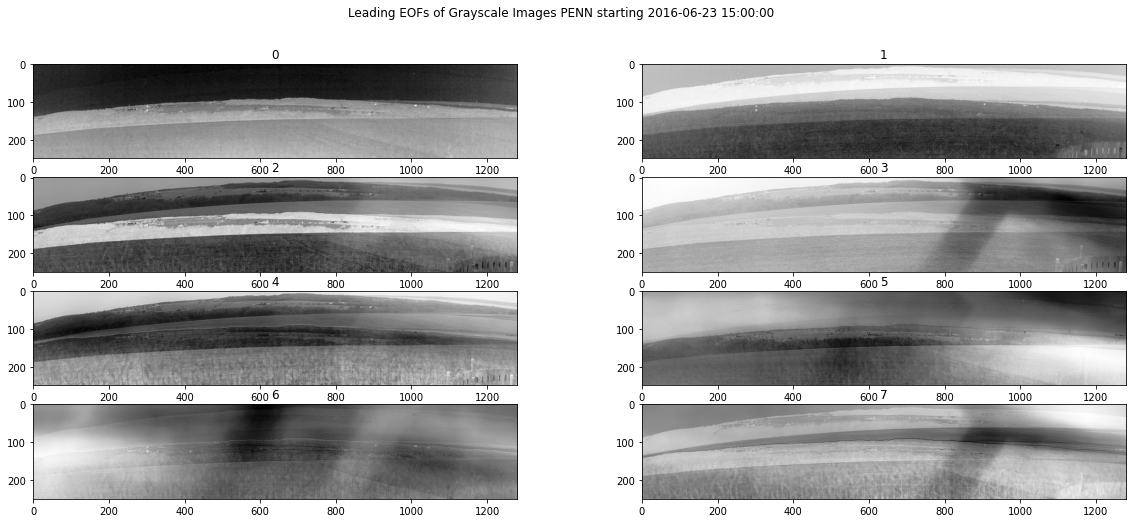

In [10]:
#plot leading EOFs
plt.rcParams['figure.figsize'] = [20, 8]
fig, axes = plt.subplots(4, 2)
for i in eofs.coords['mode']:
    axes[i // 2][i % 2].imshow(eofs.sel(mode = eofs.coords['mode'].values[i]), cmap = 'Greys_r')
    axes[i // 2][i % 2].title.set_text(str(i.values))
    #eofs.sel(mode = i).plot.pcolormesh(cmap=plt.cm.RdBu_r)
    fig.suptitle("Leading EOFs of Grayscale Images %s starting %s" % (STN, str(startdate - dt.timedelta(minutes=startdate.minute))))

IndexError: index 4 is out of bounds for axis 0 with size 4

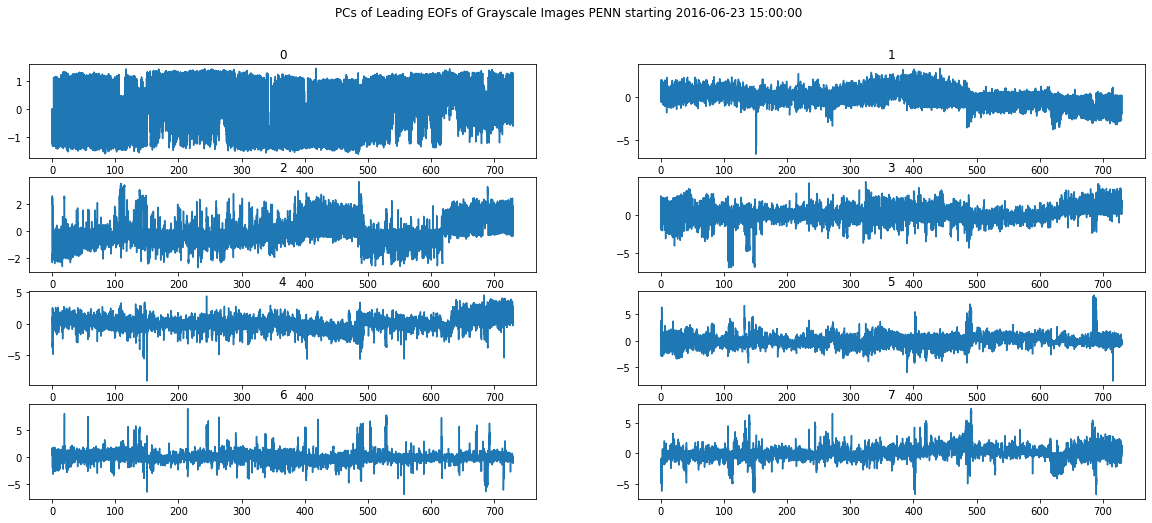

In [18]:
#plot principal component time series
pcs = solver.pcs(pcscaling = 1)#, npcs = 4)
fig, axes = plt.subplots(4, 2)
plottimes = [cftime.date2num(time, 'days since %s' % startdate) for time in pcs.coords['time'].values]
#axes[0][0].set_xlim([0, 10])
for i in pcs.coords['mode']:
    axes[i // 2][i % 2].plot(plottimes, pcs.sel(mode = pcs.coords['mode'].values[i]).values)
    axes[i // 2][i % 2].title.set_text(str(i.values))
    #eofs.sel(mode = i).plot.pcolormesh(cmap=plt.cm.RdBu_r)
    fig.suptitle("PCs of Leading EOFs of Grayscale Images %s starting %s" % (STN, str(startdate - dt.timedelta(minutes=startdate.minute))))

IndexError: index 4 is out of bounds for axis 0 with size 4

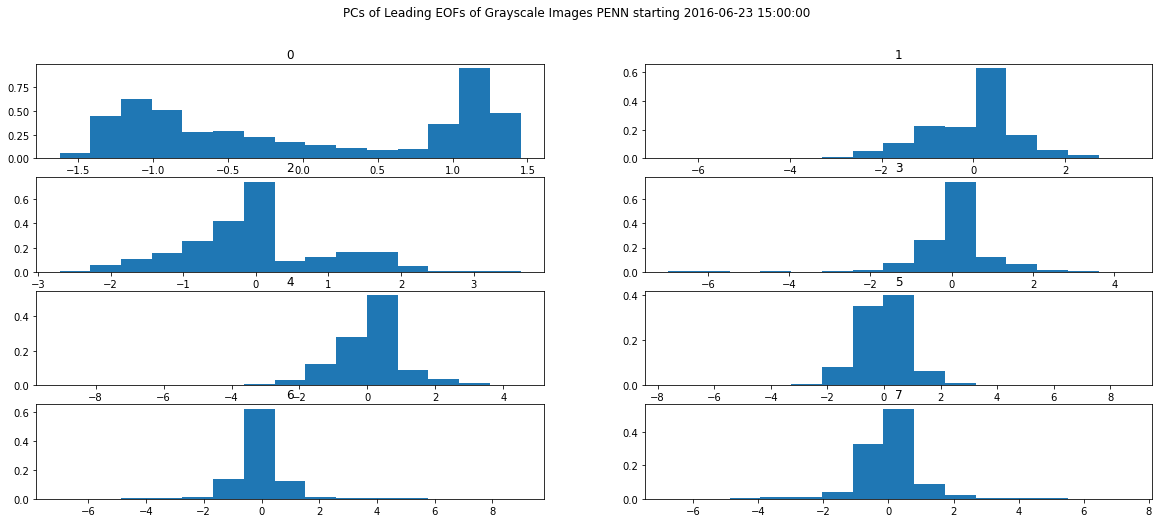

In [60]:
#histogram of pcs
fig, axes = plt.subplots(4, 2)
for i in pcs.coords['mode']:
    axes[i // 2][i % 2].hist(pcs.sel(mode = pcs.coords['mode'].values[i]).values, bins = 15, density = True)
    axes[i // 2][i % 2].title.set_text(str(i.values))
    #eofs.sel(mode = i).plot.pcolormesh(cmap=plt.cm.RdBu_r)
    fig.suptitle("PCs of Leading EOFs of Grayscale Images %s starting %s" % (STN, str(startdate - dt.timedelta(minutes=startdate.minute))))

0.10005211047420531 17271
2018-06-06 17:00:00 ['20180606T170028_PENN.jpg']
True


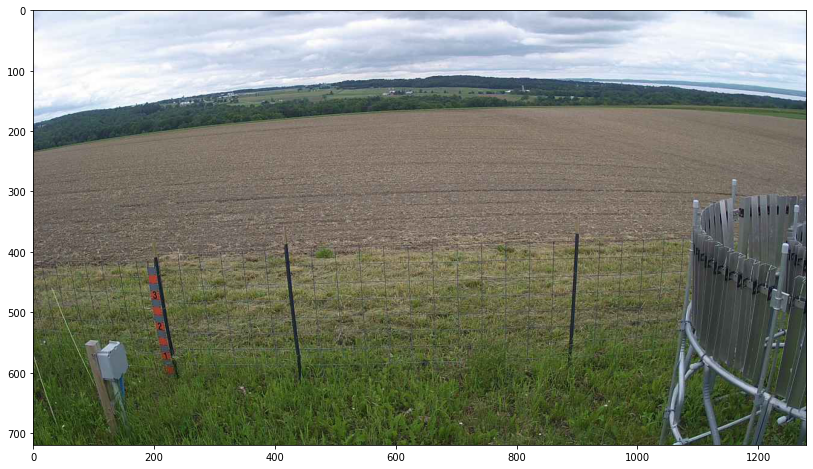

In [64]:
selpc = pcs.sel(mode = pcs.coords['mode'].values[4]).values
pctile2 = np.percentile(selpc, 100.0)
pctile1 = np.percentile(selpc, 90.0)
#print(pctile1)
idxs = np.where((selpc >= pctile1) & (selpc <= pctile2))[0]
print(len(idxs) / len(selpc), len(selpc))
seldate = timestamps[np.random.choice(idxs)]
imgsubdir = '{:04d}/{:02d}/{:02d}/{}'.format(seldate.year, seldate.month, seldate.day, STN)
os.chdir(os.path.join(IMGDIR, imgsubdir))
imgfile = glob.glob('{:04d}{:02d}{:02d}T{:02d}{:02d}*'.format(seldate.year, seldate.month, seldate.day, seldate.hour, seldate.minute // 60 * 60))
print(seldate, imgfile)
image = mpimg.imread(imgfile[0])

plt.imshow(image)
print(isdaytime(image))

In [22]:
def getASOSvisseries(ASOSstn, startdate, duration, timestep):
    #TODO add a minutes argument since not every station logs data on the hour
    """
    From the Iowa State Mesonet website, get the visibility in statute miles of an ASOS station for a time period. Exclusive of startdate + duration.
    
    :Parameters:
        ASOSstn (str): IATA or three-char code of ASOS station
        
        startdate (cftime or datetime object)
        
        duration (timedelta object): how long of a time series
        
        timestep (timedelta object): sampling time step of time series
    
    :rtype: list of timestamps (datetime object), list of visibility (floats)
    """

    enddate = startdate + duration + dt.timedelta(days = 1)
    
    timestamps = [startdate]
    for i in range(1, duration // timestep):
        timestamps.append(timestamps[i - 1] + timestep)
    
    url = 'https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station={}&data=vsby&year1={}&month1={}&day1={}&year2={}&month2={}&day2={}&tz=Etc%2FUTC&format=onlycomma&latlon=no&elev=no&missing=M&trace=T&direct=no&report_type=1&report_type=2'.format(ASOSstn, startdate.year, startdate.month, startdate.day, enddate.year, enddate.month, enddate.day)
    asosfile = urllib.request.urlopen(url)
    lines = asosfile.readlines()
    print(url)
    
    visibs = []
    timeidx = 0
    for idx in range(1, len(lines)):
        decoded_line = lines[idx].decode("utf-8").split(',')
        linetime = dt.datetime.strptime(decoded_line[1], '%Y-%m-%d %H:%M')
        if linetime > timestamps[-1]:
            break
        if linetime == timestamps[timeidx]: #if the line time matches the next desired time in the time series
            try:
                visibs.append(float(decoded_line[2][:-1]))
                #print(timeidx, len(visibs), timestamps[timeidx], linetime, visibs[-1])
            except ValueError: #if value is M (missing)
                visibs.append(np.nan)
            timeidx += 1
        if timeidx < len(timestamps) - 1 and linetime > timestamps[timeidx]: #if a desired time isn't available in the ASOS, skip ahead
            del(timestamps[timeidx])
            
    return timestamps, visibs

In [35]:
vistimestamps, visibs = getASOSvisseries(ASOS, startdate, dt.timedelta(hours = hours[1] + 100), dt.timedelta(hours = 1))
print(len(vistimestamps), len(visibs))
print(vistimestamps[192], visibs[192])

visdict = {vistimestamps[i]: visibs[i] for i in range(len(visibs))}
visda = xr.DataArray(np.zeros(pcs.coords['time'].values.shape), dims = ['time'], coords = [pcs.coords['time'].values])
for i in range(len(visda.coords['time'].values)):
    if visda.coords['time'].values[i] in visdict:
        visda.values[i] = visdict[visda.coords['time'].values[i]]
    else:
        visda.values[i] = np.nan

https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=PEO&data=vsby&year1=2016&month1=6&day1=23&year2=2018&month2=6&day2=28&tz=Etc%2FUTC&format=onlycomma&latlon=no&elev=no&missing=M&trace=T&direct=no&report_type=1&report_type=2
16711 16711
2016-07-01 17:00:00 9.0


In [59]:
from scipy import stats

visdropnans = visda.values[np.where(np.isnan(visda.values) == False)]
selpcdropnan = pcs.sel(mode = 10).values[np.where(np.isnan(visda.values) == False)]
stats.pearsonr(visdropnans, selpcdropnan)

(-0.05192861832091318, 4.0190082443810853e-11)

In [73]:
#compute Pearson's r for the first N pcs and visibility
rs = []
N = 17271
for i in range(N):
    selpcdropnan = pcs.sel(mode = i).values[np.where(np.isnan(visda.values) == False)]
    rs.append(stats.pearsonr(visdropnans, selpcdropnan)[0])

(0.0, 10.0)

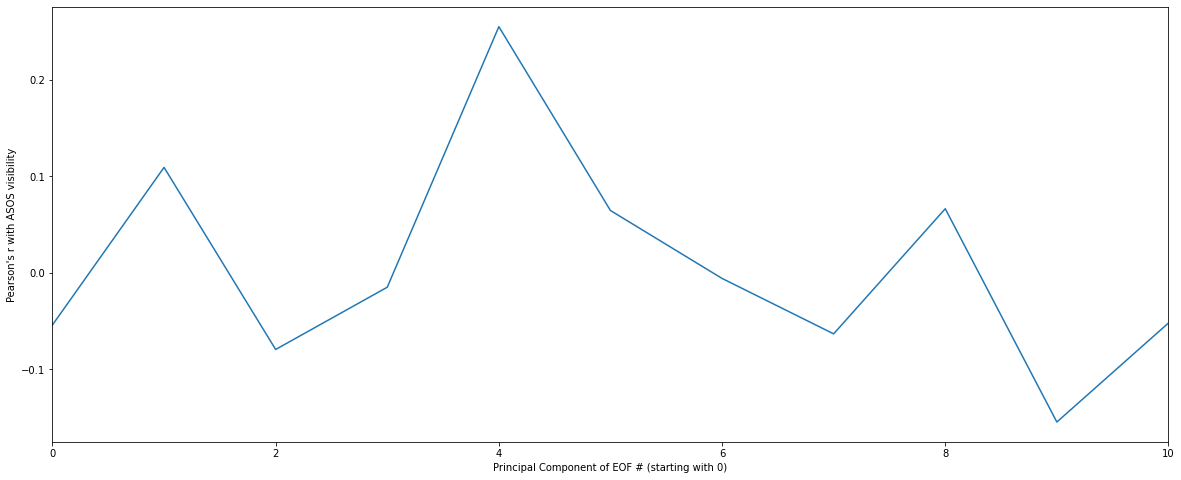

In [89]:
plt.plot(np.arange(0, N, 1), rs)
plt.xlabel('Principal Component of EOF # (starting with 0)')
plt.ylabel('Pearson\'s r with ASOS visibility')
#plt.xlim(0, 10)

Text(0, 0.5, 'Total explained variance of visibility by preceding pcs')

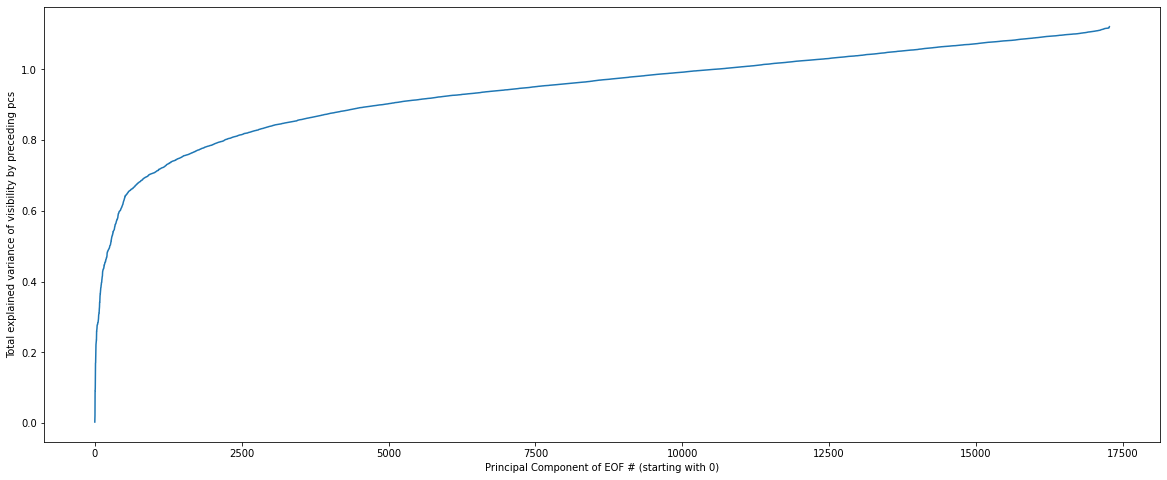

In [94]:
expl_var = [rs[0] ** 2] #sum of explained variance of visibility by linear regression with the first n pcs
for i, r in enumerate(rs[1:]):
    expl_var.append(expl_var[i] + r ** 2)
    
plt.plot(np.arange(0, N, 1), expl_var)
plt.xlabel('Principal Component of EOF # (starting with 0)')
plt.ylabel('Total explained variance of visibility by preceding pcs')
#plt.xlim(0, 10)

In [91]:
with open('/tf/visibility/x.pickle', 'wb') as f:
    pickle.dump((y0, y1, x0, x1), f)
    pickle.dump(pcs, f)
    pickle.dump(visda, f)